In [1]:
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.4 MB/s eta 0:00:00


In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
import tensorflow as tf
tf.random.set_seed(1)
from numpy.random import seed
seed(1)

In [3]:
train= pd.read_csv('/content/train.csv', parse_dates=['date'])
test= pd.read_csv('/content/test.csv', parse_dates=['date'])

In [4]:
train.describe()

,store,item,sales
count,173154.000000,173154.000000,173154.000000
mean,5.369093,5.254513,46.341707
std,2.871848,2.745023,26.712918
min,1.000000,1.000000,0.000000
25%,3.000000,3.000000,24.000000
50%,5.000000,5.000000,42.000000
75%,8.000000,8.000000,63.000000
max,10.000000,10.000000,181.000000


In [5]:
test.describe()

,id,date,store,item
count,45000.000000,45000,45000.000000,45000.00000
mean,22499.500000,2018-02-14 12:00:00.000000256,5.500000,25.50000
min,0.000000,2018-01-01 00:00:00,1.000000,1.00000
25%,11249.750000,2018-01-23 00:00:00,3.000000,13.00000
50%,22499.500000,2018-02-14 12:00:00,5.500000,25.50000
75%,33749.250000,2018-03-09 00:00:00,8.000000,38.00000
max,44999.000000,2018-03-31 00:00:00,10.000000,50.00000
std,12990.525394,NaN,2.872313,14.43103


In [6]:
train.head()

,date,store,item,sales
0,2013-01-01,1.0,1.0,13.0
1,2013-01-02,1.0,1.0,11.0
2,2013-01-03,1.0,1.0,14.0
3,2013-01-04,1.0,1.0,13.0
4,2013-01-05,1.0,1.0,10.0


In [7]:
train['date']=pd.to_datetime(train['date'], format='%Y-%m-%d', errors='coerce')

In [8]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


In [9]:
test['date']=pd.to_datetime(test['date'], format='%d.%m.%Y')

In [10]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-12-31
Max date from test set: 2018-03-31
Forecast lag size 90


In [11]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [12]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [13]:
store_daily_sales_sc = []
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=('Store %s' % store)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

In [14]:
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

In [15]:
train = train[(train['date'] >= '2017-01-01')]

In [16]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1.0,1.0,2017-01-01,19.0
1,1.0,1.0,2017-01-02,15.0
2,1.0,1.0,2017-01-03,10.0
3,1.0,1.0,2017-01-04,16.0
4,1.0,1.0,2017-01-05,14.0


In [17]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [18]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1.0,1.0,15.0,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1.0,1.0,17.0,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1.0,1.0,24.0,1.0,1.0,19.0


In [19]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [20]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [21]:
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (18925, 30)
Validation set shape (12618, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
26807,117.0,86.0,92.0,95.0,100.0,97.0,137.0,133.0,73.0,109.0,...,115.0,130.0,82.0,101.0,93.0,111.0,117.0,125.0,126.0,98.0
29322,56.0,56.0,49.0,54.0,63.0,64.0,45.0,44.0,44.0,60.0,...,40.0,48.0,45.0,46.0,47.0,61.0,77.0,55.0,63.0,53.0
14488,37.0,21.0,29.0,25.0,24.0,49.0,32.0,39.0,29.0,31.0,...,35.0,26.0,18.0,32.0,15.0,38.0,40.0,21.0,30.0,23.0
8892,40.0,44.0,34.0,36.0,23.0,35.0,31.0,30.0,37.0,40.0,...,34.0,51.0,32.0,39.0,31.0,29.0,41.0,39.0,40.0,45.0
34150,85.0,96.0,97.0,109.0,112.0,126.0,141.0,94.0,104.0,103.0,...,115.0,101.0,102.0,91.0,91.0,116.0,127.0,128.0,87.0,90.0


# Multilayer Perceptron mode or MLP for univariate analysis

In [22]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [23]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
592/592 - 4s - loss: 355.6929 - val_loss: 319.6907 - 4s/epoch - 8ms/step
Epoch 2/40
592/592 - 2s - loss: 325.2919 - val_loss: 311.3722 - 2s/epoch - 4ms/step
Epoch 3/40
592/592 - 2s - loss: 317.6042 - val_loss: 306.1883 - 2s/epoch - 4ms/step
Epoch 4/40
592/592 - 2s - loss: 315.4374 - val_loss: 303.6943 - 2s/epoch - 3ms/step
Epoch 5/40
592/592 - 2s - loss: 309.6994 - val_loss: 318.3055 - 2s/epoch - 3ms/step
Epoch 6/40
592/592 - 1s - loss: 308.3427 - val_loss: 302.7736 - 1s/epoch - 2ms/step
Epoch 7/40
592/592 - 1s - loss: 305.5888 - val_loss: 300.2849 - 1s/epoch - 2ms/step
Epoch 8/40
592/592 - 2s - loss: 303.6659 - val_loss: 306.6806 - 2s/epoch - 3ms/step
Epoch 9/40
592/592 - 1s - loss: 304.6871 - val_loss: 294.5117 - 1s/epoch - 2ms/step
Epoch 10/40
592/592 - 1s - loss: 300.6467 - val_loss: 292.0600 - 1s/epoch - 2ms/step
Epoch 11/40
592/592 - 1s - loss: 297.7984 - val_loss: 289.5738 - 1s/epoch - 2ms/step
Epoch 12/40
592/592 - 1s - loss: 296.4930 - val_loss: 310.7283 - 1s/epoch 

# CNN for Time Series Forecasting
For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
The convolutional layer should be able to identify patterns between the timesteps.
Input shape [samples, timesteps, features].


In [25]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (18925, 30, 1)
Validation set shape (12618, 30, 1)


In [26]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer.build(model_cnn.trainable_variables)
model_cnn.compile(loss='mse', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                44850     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45093 (176.14 KB)
Trainable params: 45093 (176.14 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [27]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
592/592 - 3s - loss: 363.2809 - val_loss: 319.3162 - 3s/epoch - 5ms/step
Epoch 2/40
592/592 - 3s - loss: 327.5149 - val_loss: 323.9125 - 3s/epoch - 5ms/step
Epoch 3/40
592/592 - 2s - loss: 321.8716 - val_loss: 344.2128 - 2s/epoch - 3ms/step
Epoch 4/40
592/592 - 2s - loss: 323.5994 - val_loss: 308.3242 - 2s/epoch - 3ms/step
Epoch 5/40
592/592 - 2s - loss: 317.2252 - val_loss: 317.1541 - 2s/epoch - 3ms/step
Epoch 6/40
592/592 - 2s - loss: 314.4890 - val_loss: 302.4834 - 2s/epoch - 3ms/step
Epoch 7/40
592/592 - 2s - loss: 313.1351 - val_loss: 300.4099 - 2s/epoch - 4ms/step
Epoch 8/40
592/592 - 3s - loss: 310.6273 - val_loss: 300.7942 - 3s/epoch - 5ms/step
Epoch 9/40
592/592 - 2s - loss: 311.5599 - val_loss: 297.6027 - 2s/epoch - 3ms/step
Epoch 10/40
592/592 - 2s - loss: 305.3208 - val_loss: 302.6826 - 2s/epoch - 3ms/step
Epoch 11/40
592/592 - 2s - loss: 302.7408 - val_loss: 293.9889 - 2s/epoch - 4ms/step
Epoch 12/40
592/592 - 2s - loss: 300.5609 - val_loss: 320.6909 - 2s/epoch 

# LSTM for time series forecasting


In [28]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer.build(model_lstm.trainable_variables)
model_lstm.compile(loss='mse', optimizer=optimizer)

model_lstm.summary()

lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
592/592 - 10s - loss: 479.9127 - val_loss: 318.3611 - 10s/epoch - 17ms/step
Epoch 2/40
592/592 - 9s - loss: 325.2491 - val_loss: 309.2286 - 9s/epoch - 15ms/step
Epoch 3/40
592/592 - 8s - loss: 314.8612 - val_loss: 329.7099 - 8s/epoch - 13ms/step
Epoch 4/40
592/592 - 9s - loss: 312.2711 - val_loss: 298.1877 - 9s/epoch - 16ms/step
Epoch 5/40
592/592 - 8s - loss: 303.1270 - val_loss: 298.6024 - 8s/epoch

# Hybrid model (CNN-LSTM)  for Time Series Forecasting

When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence

In [29]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (18925, 2, 15, 1)
Validation set shape (12618, 2, 15, 1)


In [30]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer.build(model_cnn_lstm.trainable_variables)
model_cnn_lstm.compile(loss='mse', optimizer=optimizer)

In [31]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
592/592 - 5s - loss: 383.1679 - val_loss: 355.2108 - 5s/epoch - 8ms/step
Epoch 2/40
592/592 - 4s - loss: 354.7002 - val_loss: 341.6364 - 4s/epoch - 7ms/step
Epoch 3/40
592/592 - 6s - loss: 346.0713 - val_loss: 333.4921 - 6s/epoch - 9ms/step
Epoch 4/40
592/592 - 4s - loss: 344.7610 - val_loss: 330.0545 - 4s/epoch - 7ms/step
Epoch 5/40
592/592 - 4s - loss: 338.8859 - val_loss: 340.5448 - 4s/epoch - 6ms/step
Epoch 6/40
592/592 - 5s - loss: 339.1416 - val_loss: 348.0293 - 5s/epoch - 9ms/step
Epoch 7/40
592/592 - 4s - loss: 339.4425 - val_loss: 328.3640 - 4s/epoch - 6ms/step
Epoch 8/40
592/592 - 4s - loss: 336.9592 - val_loss: 337.6566 - 4s/epoch - 7ms/step
Epoch 9/40
592/592 - 5s - loss: 338.4512 - val_loss: 329.7217 - 5s/epoch - 9ms/step
Epoch 10/40
592/592 - 4s - loss: 332.8252 - val_loss: 322.1896 - 4s/epoch - 6ms/step
Epoch 11/40
592/592 - 4s - loss: 328.6449 - val_loss: 319.0360 - 4s/epoch - 7ms/step
Epoch 12/40
592/592 - 5s - loss: 324.4875 - val_loss: 340.9169 - 5s/epoch 

# Model Comparision and conclusion

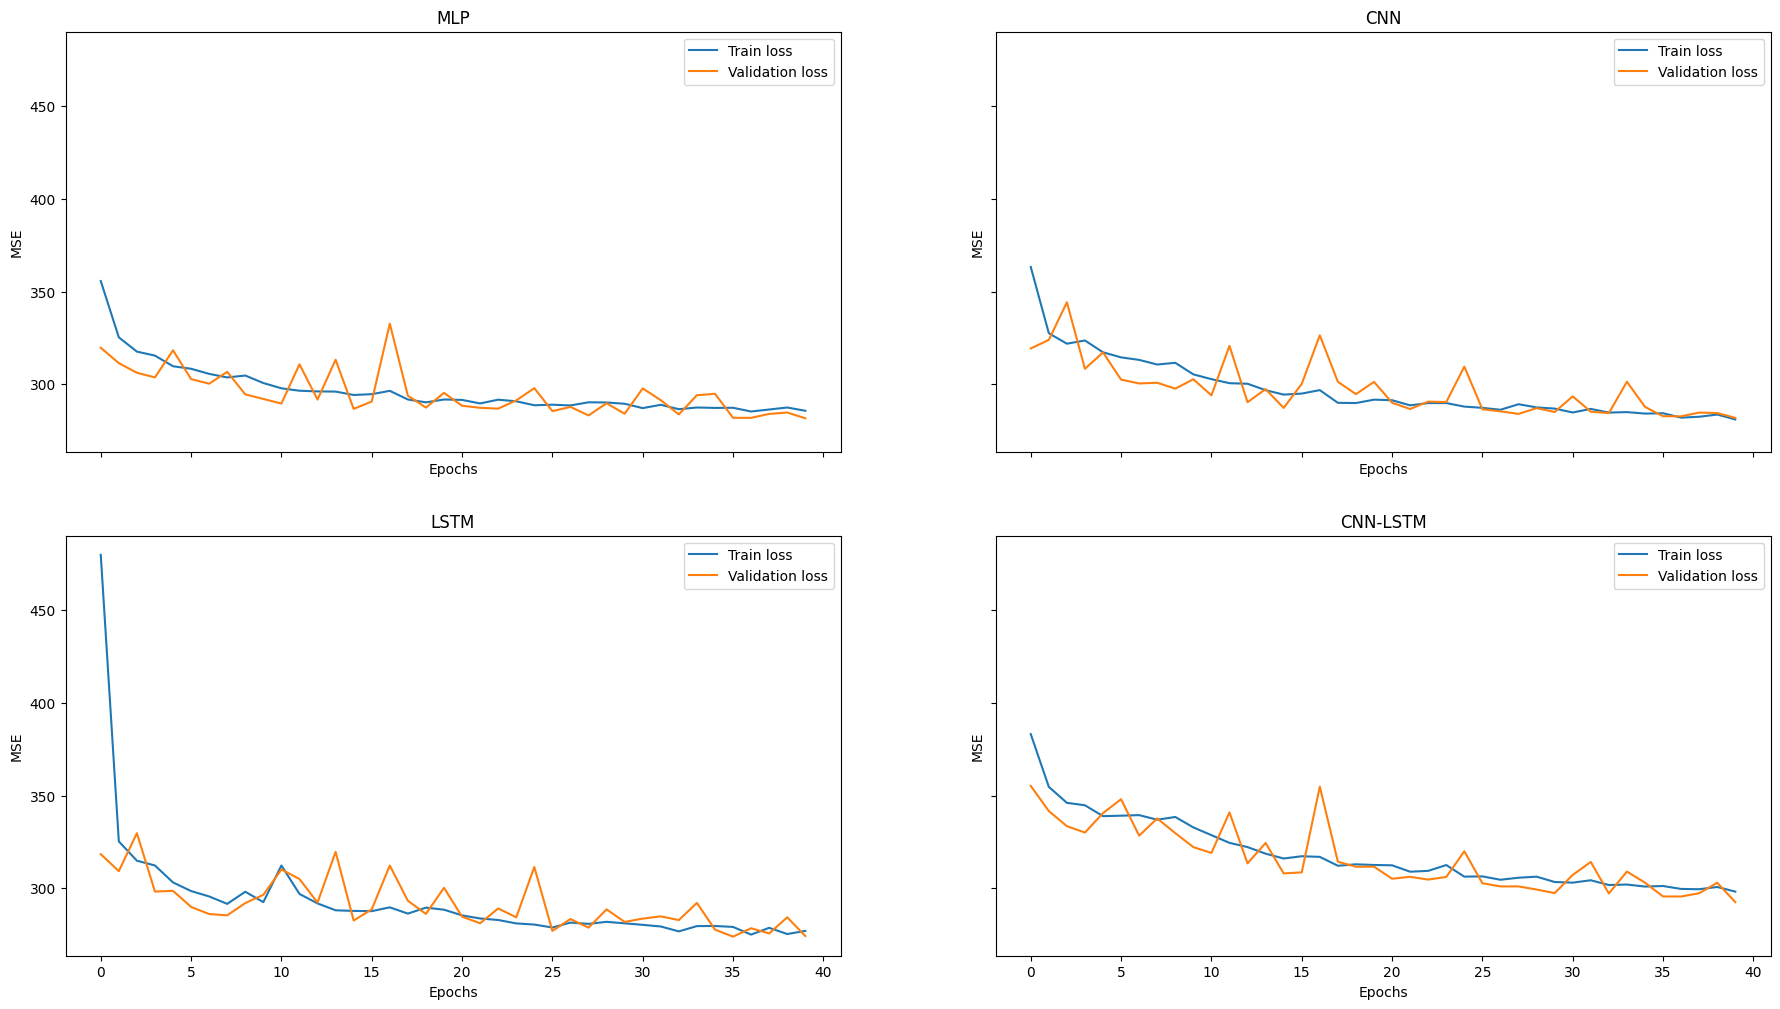

In [32]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

MLP On training and vallidation

In [33]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

395/395 [==============================] - 0s 1ms/step
Train rmse: 16.72589393599847
Validation rmse: 16.7814099036237


CNN on training and validation

In [34]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

395/395 [==============================] - 1s 2ms/step
Train rmse: 16.549317585118665
Validation rmse: 16.788437631894727


LSTM on training and validation

In [35]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

395/395 [==============================] - 1s 2ms/step
Train rmse: 16.440395820278997
Validation rmse: 16.788437631894727


Hybrid model on training and validation

In [36]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

395/395 [==============================] - 1s 2ms/step
Train rmse: 17.086764194271527
Validation rmse: 17.10203915486894


## CONCLUSION


Based on the provided RMSE values, the LSTM model performs slightly better than the MLP and CNN-LSTM models on both the training and validation sets. It has the lowest training RMSE (16.44) and the same validation RMSE (16.78) as the MLP model, indicating better generalization compared to the CNN-LSTM model, which has higher RMSE values on both sets.

However, the differences in RMSE are relatively small, suggesting that all three models have similar performance capabilities. Further experimentation and fine-tuning might be needed to determine a clear winner.